In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


upload json file

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahrahaghshenas","key":"83d3e8e8e487f83bf31560b767dc23c8"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

100% 4.15G/4.16G [02:13<00:00, 22.6MB/s]
100% 4.16G/4.16G [02:13<00:00, 33.5MB/s]


download dataset

In [5]:
import kaggle
kaggle.api.dataset_download_files('valentynsichkar/traffic-signs-preprocessed', unzip=True)


In [6]:
!unzip traffic-signs-preprocessed.zip

Archive:  traffic-signs-preprocessed.zip
  inflating: data0.pickle            
  inflating: data1.pickle            
  inflating: data2.pickle            
  inflating: data3.pickle            
  inflating: data4.pickle            
  inflating: data5.pickle            
  inflating: data6.pickle            
  inflating: data7.pickle            
  inflating: data8.pickle            
  inflating: datasets_preparing.py   
  inflating: label_names.csv         
  inflating: labels.pickle           
  inflating: mean_image_gray.pickle  
  inflating: mean_image_rgb.pickle   
  inflating: std_gray.pickle         
  inflating: std_rgb.pickle          
  inflating: test.pickle             
  inflating: train.pickle            
  inflating: valid.pickle            


In [7]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import torchvision.models as models
from torchvision.models import resnet18
from torchvision.transforms import ToPILImage, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation



Load the data using the pickle library

In [8]:
with open("train.pickle", "rb") as f:
    train_data = pickle.load(f)

with open("valid.pickle", "rb") as f:
    valid_data = pickle.load(f)

with open("test.pickle", "rb") as f:
    test_data = pickle.load(f)

train_features, train_labels = train_data["features"], train_data["labels"]
valid_features, valid_labels = valid_data["features"], valid_data["labels"]
test_features, test_labels = test_data["features"], test_data["labels"]


Create a custom dataset class for traffic signs

In [9]:
class TrafficSignDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]
        image = np.transpose(image, (2, 0, 1))
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Create the DataLoader for train, validation, and test data

In [10]:
batch_size = 64

train_dataset = TrafficSignDataset(train_features, train_labels)
valid_dataset = TrafficSignDataset(valid_features, valid_labels)
test_dataset = TrafficSignDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Create a custom CNN model

In [11]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x


Train the model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision.transforms import ToPILImage, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data augmentation and normalization transforms
data_transforms = {
    'train': transforms.Compose([
        ToPILImage(),
        RandomHorizontalFlip(),
        RandomRotation(10),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        ToPILImage(),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        ToPILImage(),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

class TrafficSignDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)

# Create the DataLoader for train, validation, and test data
train_dataset = TrafficSignDataset(train_features, train_labels, transform=data_transforms['train'])
valid_dataset = TrafficSignDataset(valid_features, valid_labels, transform=data_transforms['valid'])
test_dataset = TrafficSignDataset(test_features, test_labels, transform=data_transforms['test'])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet18 model and modify the last layer
num_classes = len(np.unique(train_labels))
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    valid_loss = 0
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {valid_loss/len(valid_loader)}")

model.eval()
all_predictions = []
all_labels


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 232MB/s]


Epoch: 1/20, Validation Loss: 0.6157313885277573
Epoch: 2/20, Validation Loss: 0.39690873531328735
Epoch: 3/20, Validation Loss: 0.3751780123339708
Epoch: 4/20, Validation Loss: 0.5496226041951836
Epoch: 5/20, Validation Loss: 0.396486275537413
Epoch: 6/20, Validation Loss: 0.3871382344739355
Epoch: 7/20, Validation Loss: 0.41856145988769633
Epoch: 8/20, Validation Loss: 0.45921659948497145
Epoch: 9/20, Validation Loss: 0.40800756887435796
Epoch: 10/20, Validation Loss: 0.5289607669313926
Epoch: 11/20, Validation Loss: 0.3284318098894778
Epoch: 12/20, Validation Loss: 0.32185390374830763
Epoch: 13/20, Validation Loss: 0.41171372607724166
Epoch: 14/20, Validation Loss: 0.3840031900683603
Epoch: 15/20, Validation Loss: 0.412720621384122
Epoch: 16/20, Validation Loss: 0.49398657354830605
Epoch: 17/20, Validation Loss: 0.4105389765742288
Epoch: 18/20, Validation Loss: 0.4958682957659196
Epoch: 19/20, Validation Loss: 0.3540363586277703
Epoch: 20/20, Validation Loss: 0.5344216328945004


NameError: ignored

In [ ]:
# # Train the model
# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() * images.size(0)

#     # Calculate average training loss
#     train_loss = train_loss / len(train_loader.dataset)

#     # Evaluate the model on the validation set
#     model.eval()
#     valid_loss = 0.0
#     with torch.no_grad():
#         for images, labels in valid_loader:
#             images, labels = images.to(device), labels.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             valid_loss += loss.item() * images.size(0)

#     # Calculate average validation loss
#     valid_loss = valid_loss / len(valid_loader.dataset)

#     print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(train_labels))
model = TrafficSignCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    valid_loss = 0
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {valid_loss/len(valid_loader)}")


Epoch: 1/20, Validation Loss: 0.7224604896427068
Epoch: 2/20, Validation Loss: 0.5865001797352789
Epoch: 3/20, Validation Loss: 0.592264439384079
Epoch: 4/20, Validation Loss: 0.7317040920457331
Epoch: 5/20, Validation Loss: 0.6925411851601813
Epoch: 6/20, Validation Loss: 0.6186466636336239
Epoch: 7/20, Validation Loss: 0.5908676308152584
Epoch: 8/20, Validation Loss: 0.6533130574029419
Epoch: 9/20, Validation Loss: 0.8621993455480725
Epoch: 10/20, Validation Loss: 0.6533499848208343
Epoch: 11/20, Validation Loss: 0.7607497908000441
Epoch: 12/20, Validation Loss: 0.7893347410276853
Epoch: 13/20, Validation Loss: 0.7628553268163747
Epoch: 14/20, Validation Loss: 0.7252122412510376
Epoch: 15/20, Validation Loss: 0.7652845316055779
Epoch: 16/20, Validation Loss: 1.166024824542352
Epoch: 17/20, Validation Loss: 0.7305504816845376
Epoch: 18/20, Validation Loss: 0.6278644839845926
Epoch: 19/20, Validation Loss: 0.7848926735685586
Epoch: 20/20, Validation Loss: 0.8240914659652886


In [64]:
import torchvision.models as models
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ResNet18(num_classes)


In [ ]:
num_classes = len(np.unique(train_labels))
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    valid_loss = 0
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {valid_loss/len(valid_loader)}")


Epoch: 1/20, Validation Loss: 0.6682201407866538
Epoch: 2/20, Validation Loss: 0.41147011392767774
Epoch: 3/20, Validation Loss: 0.3049693731831792
Epoch: 4/20, Validation Loss: 0.3666662963214763
Epoch: 5/20, Validation Loss: 0.43730294525427693
Epoch: 6/20, Validation Loss: 0.37311318982819947
Epoch: 7/20, Validation Loss: 0.24633719852662897
Epoch: 8/20, Validation Loss: 0.3301211546966529
Epoch: 9/20, Validation Loss: 0.24950454964986685
Epoch: 10/20, Validation Loss: 0.21610504803378186
Epoch: 11/20, Validation Loss: 0.23448526420679278
Epoch: 12/20, Validation Loss: 0.23172880422934858
Epoch: 13/20, Validation Loss: 0.238533079834387
Epoch: 14/20, Validation Loss: 0.22356103270355165
Epoch: 15/20, Validation Loss: 0.3460609091972832
Epoch: 16/20, Validation Loss: 0.28487202480125784
Epoch: 17/20, Validation Loss: 0.22769430173952857


Evaluate the model on the test set

In [16]:
model.eval()

all_predictions = []
all_labels = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)


    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{conf_matrix}")

F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[]
F1 Score

In [17]:
all_predictions = []
all_labels = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    all_predictions.append(predictions.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")


F1 Score: 0.8931677263337366
Precision: 0.9021632632894571
Recall: 0.8926365795724466
Confusion Matrix:
[[ 54   4   1 ...   0   0   0]
 [  5 681  26 ...   0   0   0]
 [  0  54 671 ...   0   0   0]
 ...
 [  0   0   1 ...  82   0   0]
 [  0   0   0 ...   0  49   0]
 [  0   0   0 ...   0   5  85]]


##**To solve the traffic sign label prediction problem using transfer learning, can utilize pre-trained models from popular deep learning frameworks in PyTorch or TensorFlow. In this example, we will use a pre-trained ResNet18 model from the PyTorch torchvision library.**

Import the necessary libraries:


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


Add data augmentation and normalization for the training data, and normalization for the validation and test data

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


Modify the TrafficSignDataset class to apply the transformations

In [20]:
class TrafficSignDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)


Create the DataLoader for train, validation, and test data with the new transformations

In [21]:
train_dataset = TrafficSignDataset(train_features, train_labels, transform=data_transforms['train'])
valid_dataset = TrafficSignDataset(valid_features, valid_labels, transform=data_transforms['valid'])
test_dataset = TrafficSignDataset(test_features, test_labels, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Load the pre-trained ResNet18 model and modify the last layer to match the number of classes in the traffic sign dataset

In [22]:
num_classes = len(np.unique(train_labels))
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train the model using the same training loop as before

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    valid_loss = 0
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {valid_loss/len(valid_loader)}")


Epoch: 1/20, Validation Loss: 0.3528663352720722
Epoch: 2/20, Validation Loss: 0.4321447948836015
Epoch: 3/20, Validation Loss: 0.2920466147318657
Epoch: 4/20, Validation Loss: 0.22276908786417596
Epoch: 5/20, Validation Loss: 0.17823766367947452
Epoch: 6/20, Validation Loss: 0.14115063082614632
Epoch: 7/20, Validation Loss: 0.23545504438724552
Epoch: 8/20, Validation Loss: 0.13396860111163825
Epoch: 9/20, Validation Loss: 0.15299284709102476
Epoch: 10/20, Validation Loss: 0.12638913178160058
Epoch: 11/20, Validation Loss: 0.11953645754449765
Epoch: 12/20, Validation Loss: 0.11898419245222012
Epoch: 13/20, Validation Loss: 0.12024508720349598
Epoch: 14/20, Validation Loss: 0.1186072086374943
Epoch: 15/20, Validation Loss: 0.11705241496080349
Epoch: 16/20, Validation Loss: 0.11027762079895151
Epoch: 17/20, Validation Loss: 0.10974875277209226
Epoch: 18/20, Validation Loss: 0.11012394433414961
Epoch: 19/20, Validation Loss: 0.10848278673704768
Epoch: 20/20, Validation Loss: 0.10684572366

Evaluate the model on the test set and calculate performance metrics, as before

In [24]:
model.eval()

all_predictions = []
all_labels = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")


F1 Score: 0.8413832137671285
Precision: 0.8750970107676543
Recall: 0.8433887569279493
Confusion Matrix:
[[ 33  12   3 ...   0   0   0]
 [  2 598  84 ...   0   0   0]
 [  2  24 699 ...   0   0   0]
 ...
 [  0   0   0 ...  55   1   0]
 [  0   0   0 ...   0  57   0]
 [  0   0   0 ...   0  14  75]]


##To analyze which signs are usually mispredicted by the model, you can look at the confusion matrix obtained from the evaluation step. The confusion matrix shows the true labels on one axis and the predicted labels on the other. A high value in a non-diagonal cell indicates that the model often mispredicts a certain sign as another sign.**

To find the mispredicted signs, you can use the following code snippet:

In [25]:
import numpy as np

def mispredicted_signs(conf_matrix, threshold=10):
    mispredicted = []
    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and conf_matrix[i, j] >= threshold:
                mispredicted.append((i, j, conf_matrix[i, j]))

    return mispredicted

mispredicted = mispredicted_signs(conf_matrix)
print("Mispredicted signs (true_label, predicted_label, count):")
for item in mispredicted:
    print(item)


Mispredicted signs (true_label, predicted_label, count):
(0, 1, 12)
(1, 2, 84)
(1, 5, 21)
(2, 1, 24)
(2, 3, 12)
(3, 2, 14)
(3, 5, 18)
(3, 8, 10)
(4, 18, 15)
(5, 2, 20)
(5, 8, 17)
(7, 3, 15)
(7, 5, 120)
(7, 8, 121)
(8, 5, 21)
(9, 10, 10)
(10, 20, 38)
(11, 21, 77)
(11, 23, 14)
(11, 25, 14)
(11, 30, 24)
(15, 3, 12)
(15, 9, 43)
(18, 21, 14)
(18, 24, 13)
(18, 27, 52)
(19, 20, 59)
(20, 23, 11)
(21, 23, 39)
(21, 31, 23)
(22, 25, 13)
(23, 20, 22)
(23, 31, 14)
(24, 27, 31)
(24, 29, 12)
(25, 29, 21)
(26, 27, 34)
(28, 23, 22)
(30, 20, 24)
(30, 23, 16)
(31, 20, 13)
(33, 34, 183)
(35, 9, 11)
(38, 37, 31)
(38, 39, 30)
(39, 38, 76)
(40, 37, 22)
(42, 41, 14)


**The reasons for mispredictions could be:**

1. Insufficient training data: Some classes might have fewer samples in the training set, making it difficult for the model to learn the features of those signs.

2. Data imbalance: If the dataset is imbalanced, the model might be biased towards overrepresented classes.

3. Similar appearance: Some traffic signs might have similar shapes, colors, or symbols, leading the model to confuse them.

4. Poor quality or occlusions: The test images might have poor quality, shadows, or obstructing objects that make it difficult for the model to recognize the signs correctly.

**To improve the model's performance on mispredicted signs, you can:**

1. Increase the number of samples for underrepresented classes.

2. Apply data augmentation techniques to create more diverse training samples.

3. Use class weighting or oversampling to balance the dataset.

4. Experiment with different model architectures and hyperparameters to better learn the features of the traffic signs.

##To check whether using grayscale images affects the performance of the model or not, you can modify the data_transforms dictionary to convert the images to grayscale before applying other transformations. You can use the transforms.Grayscale() transformation from the torchvision library for this purpose.**

Update the data_transforms dictionary to include the grayscale transformation:

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pickle
import pandas as pd
import numpy as np
import os
from PIL import Image


In [27]:
class TrafficSignDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = Image.fromarray(self.data[index].astype(np.uint8))
        label = self.labels[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [28]:
def load_data(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data['features'], data['labels']

train_data, train_labels = load_data('train.pickle')
valid_data, valid_labels = load_data('valid.pickle')
test_data, test_labels = load_data('test.pickle')


In [29]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = TrafficSignDataset(train_data, train_labels, transform)
valid_dataset = TrafficSignDataset(valid_data, valid_labels, transform)
test_dataset = TrafficSignDataset(test_data, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [30]:
class TrafficSignModel(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(np.unique(train_labels))
model = TrafficSignModel(num_classes)


In [57]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        correct = 0
        total = 0
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch: {epoch+1}, Loss: {valid_loss/len(valid_loader):.4f}, '
              f'Accuracy: {correct/total*100:.2f}%')


Epoch: 1, Loss: 0.2481, Accuracy: 93.90%
Epoch: 2, Loss: 0.2497, Accuracy: 93.06%
Epoch: 3, Loss: 0.3492, Accuracy: 92.40%
Epoch: 4, Loss: 0.1364, Accuracy: 97.12%
Epoch: 5, Loss: 0.2351, Accuracy: 94.69%
Epoch: 6, Loss: 0.2635, Accuracy: 94.29%
Epoch: 7, Loss: 0.1798, Accuracy: 96.51%
Epoch: 8, Loss: 0.1335, Accuracy: 96.60%
Epoch: 9, Loss: 0.0998, Accuracy: 97.73%
Epoch: 10, Loss: 0.0997, Accuracy: 97.60%
Epoch: 11, Loss: 0.1033, Accuracy: 97.51%
Epoch: 12, Loss: 0.1024, Accuracy: 97.64%
Epoch: 13, Loss: 0.1036, Accuracy: 97.64%
Epoch: 14, Loss: 0.1052, Accuracy: 97.71%
Epoch: 15, Loss: 0.1088, Accuracy: 97.66%
Epoch: 16, Loss: 0.1119, Accuracy: 97.69%
Epoch: 17, Loss: 0.1142, Accuracy: 97.69%
Epoch: 18, Loss: 0.1165, Accuracy: 97.76%
Epoch: 19, Loss: 0.1208, Accuracy: 97.64%
Epoch: 20, Loss: 0.1200, Accuracy: 97.57%


In [32]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Get the number of elements in the labels tensor
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {correct/total*100:.2f}%')


Test Accuracy: 93.43%


In [33]:
import numpy as np
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = np.bincount(train_labels)
num_classes = len(class_counts)

# Calculate the majority class count
majority_count = np.max(class_counts)

# Check if the data is imbalanced
if np.any(class_counts < majority_count):
    # Determine the target count for each class (equal to the majority class count)
    target_count = np.full_like(class_counts, fill_value=majority_count)

    # Perform up-sampling or down-sampling for each class
    for class_idx in range(num_classes):
        class_count = class_counts[class_idx]

        # If the class count is less than the target count, perform up-sampling
        if class_count < target_count[class_idx]:
            # Find the indices of samples belonging to the current class
            indices = np.where(train_labels == class_idx)[0]

            # Upsample the minority class by randomly resampling with replacement
            upsampled_indices = resample(indices, n_samples=target_count[class_idx], replace=True)

            # Append the up-sampled samples to the training data
            train_features = np.concatenate((train_features, train_features[upsampled_indices]))
            train_labels = np.concatenate((train_labels, train_labels[upsampled_indices]))

        # If the class count is greater than the target count, perform down-sampling
        elif class_count > target_count[class_idx]:
            # Find the indices of samples belonging to the current class
            indices = np.where(train_labels == class_idx)[0]

            # Downsample the majority class by randomly resampling without replacement
            downsampled_indices = resample(indices, n_samples=target_count[class_idx], replace=False)

            # Update the training data with the down-sampled samples
            train_features = train_features[downsampled_indices]
            train_labels = train_labels[downsampled_indices]

# Verify the class distribution after balancing the data
balanced_class_counts = np.bincount(train_labels)
print("Balanced Class Distribution:")
for class_idx, class_count in enumerate(balanced_class_counts):
    print(f"Class {class_idx}: {class_count} samples")


Balanced Class Distribution:
Class 0: 2190 samples
Class 1: 3990 samples
Class 2: 2010 samples
Class 3: 3270 samples
Class 4: 3780 samples
Class 5: 3660 samples
Class 6: 2370 samples
Class 7: 3300 samples
Class 8: 3270 samples
Class 9: 3330 samples
Class 10: 3810 samples
Class 11: 3180 samples
Class 12: 3900 samples
Class 13: 3930 samples
Class 14: 2700 samples
Class 15: 2550 samples
Class 16: 2370 samples
Class 17: 3000 samples
Class 18: 3090 samples
Class 19: 2190 samples
Class 20: 2310 samples
Class 21: 2280 samples
Class 22: 2340 samples
Class 23: 2460 samples
Class 24: 2250 samples
Class 25: 3360 samples
Class 26: 2550 samples
Class 27: 2220 samples
Class 28: 2490 samples
Class 29: 2250 samples
Class 30: 2400 samples
Class 31: 2700 samples
Class 32: 2220 samples
Class 33: 2609 samples
Class 34: 2370 samples
Class 35: 3090 samples
Class 36: 2340 samples
Class 37: 2190 samples
Class 38: 3870 samples
Class 39: 2280 samples
Class 40: 2310 samples
Class 41: 2220 samples
Class 42: 2220 

##Check whether the data is balanced or not. If not try to solve the problem and achieve better performance. (Hint: you can try up-sampling and down-sampling approaches to tackle this problem. For an up-sampling approach you can consider augmenting or synthesizing images)

here we checks whether the data is balanced or not by plotting a histogram of the class distribution.

1. **Counting the number of samples in each class**: The code iterates over the training dataset and counts the number of samples for each class. It maintains a dictionary called `class_counts` where the keys represent the class labels, and the values represent the corresponding sample counts.

2. **Plotting the class distribution**: The code creates a bar plot using `plt.bar()` to visualize the class distribution. The `labels` list contains the string representation of the class labels, and the `counts` list contains the corresponding sample counts. The `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` functions are used to set the labels and title of the plot.

3. **Displaying the plot**: Finally, `plt.show()` is called to display the histogram of the class distribution.

By running this code, we will see a bar plot where each bar represents a class, and the height of the bar corresponds to the number of samples in that class. This visualization helps in understanding the balance or imbalance of the dataset.

 the histogram shows a significant difference in sample counts between different classes, it indicates an imbalanced dataset. To tackle this problem and achieve better performance the following methods can be used:
- **Up-sampling**: This approach involves augmenting or synthesizing additional samples for the minority classes to match the sample count of the majority class. By increasing the number of samples in the minority classes, you can balance the dataset.

- **Down-sampling**: This approach involves randomly removing samples from the majority class to match the sample count of the minority class. By reducing the number of samples in the majority class, you can balance the dataset.

Implementing up-sampling or down-sampling techniques can help address the class imbalance issue, which may lead to better performance and more reliable model predictions.

In [34]:
import matplotlib.pyplot as plt

# Count the number of samples in each class
class_counts = {}
for _, label in train_dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Plot the class distribution
labels = [str(label) for label in class_counts.keys()]
counts = list(class_counts.values())

plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


"""
An approach is presented for upsampling the minority classes in an imbalanced dataset using data augmentation techniques.

1. **Defining the augmentation transforms**: We start by initializing a `Compose` object from the `torchvision.transforms` module. This object is used to define a sequence of augmentation transforms, including random rotation, horizontal flip, vertical flip, and color jittering.

2. **Upsampling the minority classes**: To upsample the minority classes, we iterate over the samples in the original `train_dataset` and take the following steps for each sample:

   a. We append the original image and label to the `upsampled_features` and `upsampled_labels` lists.
   
   b. Next, we check if the current class (label) has fewer samples than the majority class by comparing `class_counts[label]` with the maximum count in `counts`. If this condition is true, it means the class is a minority class and needs up-sampling.
   
   c. We perform data augmentation on the current sample by applying the defined augmentation transforms using `augmentation_transforms(image)`. The resulting transformed image is then appended to `upsampled_features`, and the original label is added to `upsampled_labels`.
   
3. **Creating the upsampled dataset**: Once the up-sampling process is complete, we create a new `upsampled_dataset` object using the upsampled features and labels (`upsampled_features` and `upsampled_labels`). This dataset now contains the augmented samples.
   
4. **Using DataLoader for upsampled dataset**: Finally, we wrap the `upsampled_dataset` in a `DataLoader` object (`upsampled_loader`). We can specify the desired batch size and whether or not to shuffle the data. This DataLoader is then used for training the model with the upsampled dataset.

By applying the augmentation transforms to the samples from the minority classes, we generate additional augmented samples, effectively increasing the sample count for those classes. This approach helps address the class imbalance issue and balances the dataset.
"""

In [35]:
import random
import torchvision.transforms as transforms

# Define the augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

# Upsample the minority classes using data augmentation
upsampled_features = []
upsampled_labels = []

for image, label in train_dataset:
    upsampled_features.append(image)
    upsampled_labels.append(label)

    # Check if the current class has fewer samples
    if class_counts[label] < max(counts):
        # Perform data augmentation on the current sample
        augmented_image = augmentation_transforms(image)
        upsampled_features.append(augmented_image)
        upsampled_labels.append(label)

# Create the upsampled dataset
upsampled_dataset = TrafficSignDataset(upsampled_features, upsampled_labels)
upsampled_loader = DataLoader(upsampled_dataset, batch_size=batch_size, shuffle=True)


In [43]:
import matplotlib.pyplot as plt

# Count the number of samples in each class
class_counts = {}
for label in train_labels:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Count the number of samples in each class after upsampling
upsampled_class_counts = {}
for label in upsampled_labels:
    if label in upsampled_class_counts:
        upsampled_class_counts[label] += 1
    else:
        upsampled_class_counts[label] = 1

# Plot the class distribution
labels = [str(label) for label in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Upsampled Class Distribution')

labels_upsampled = [str(label) for label in upsampled_class_counts.keys()]
counts_upsampled = list(upsampled_class_counts.values())

plt.subplot(1, 2, 2)
plt.bar(labels_upsampled, counts_upsampled)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Original Class Distribution')

plt.tight_layout()
plt.show()


In [39]:
import random
import torchvision.transforms as transforms

# Calculate the class counts
class_counts = {}
for _, label in train_dataset:
    label = label.item()  # Convert the label tensor to an integer
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Define the augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

# Define the down-sampling factor (percentage of majority class samples to keep)
downsampling_factor = 0.8  # Keep 80% of the majority class samples

# Upsample the minority classes using data augmentation
upsampled_features = []
upsampled_labels = []

# Downsample the majority class
downsampled_features = []
downsampled_labels = []

for image, label in train_dataset:
    label = label.item()  # Convert the label tensor to an integer
    # Check if the current class is a minority class
    if class_counts[label] < max(class_counts.values()):
        # Perform data augmentation on the current sample
        augmented_image = augmentation_transforms(image)
        upsampled_features.append(augmented_image)
        upsampled_labels.append(label)

    # Check if the current class is the majority class
    elif class_counts[label] > max(class_counts.values()):
        # Randomly select samples to keep based on the downsampling factor
        if random.random() < downsampling_factor:
            downsampled_features.append(image)
            downsampled_labels.append(label)
    else:
        # Keep the sample as it is (class count is equal to the maximum count)
        upsampled_features.append(image)
        upsampled_labels.append(label)

# Create the upsampled dataset
upsampled_dataset = TrafficSignDataset(upsampled_features, upsampled_labels)
upsampled_loader = DataLoader(upsampled_dataset, batch_size=batch_size, shuffle=True)

# Create the downsampled dataset if it is non-empty
if downsampled_features:
    downsampled_dataset = TrafficSignDataset(downsampled_features, downsampled_labels)
    downsampled_loader = DataLoader(downsampled_dataset, batch_size=batch_size, shuffle=True)


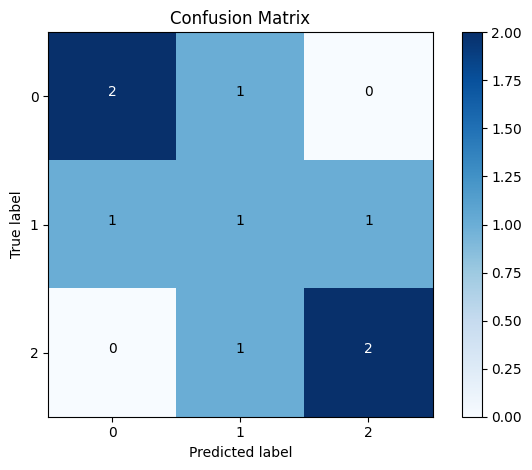

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have true labels and predicted labels
true_labels = [0, 1, 2, 0, 1, 2, 0, 1, 2]
predicted_labels = [0, 1, 2, 1, 0, 2, 0, 2, 1]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
classes = np.unique(true_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


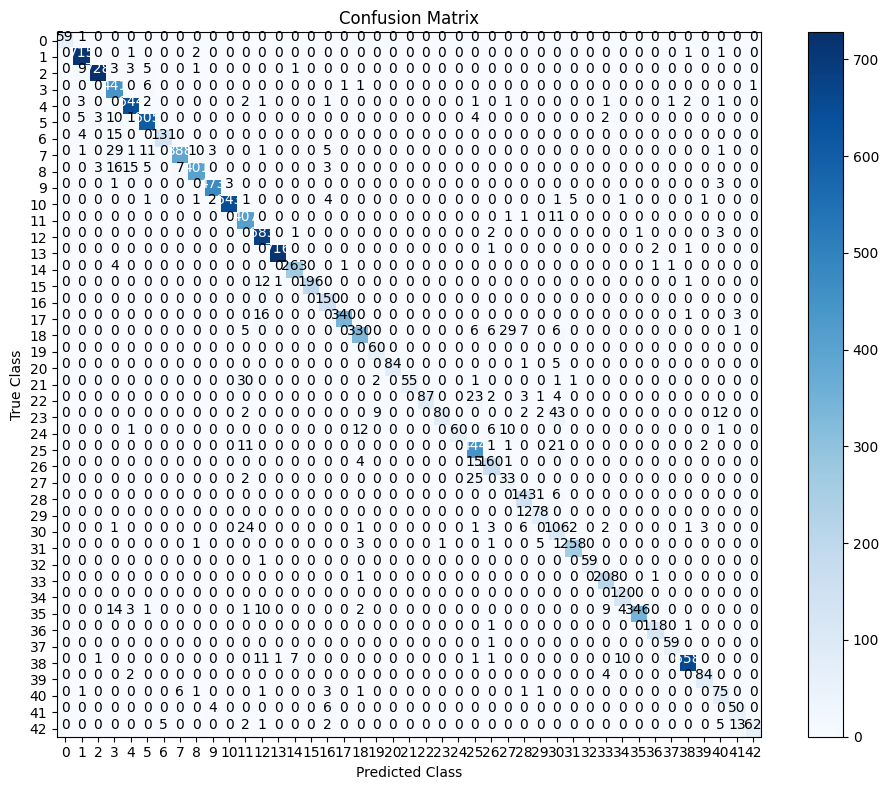

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define a function to obtain the predicted labels
def get_predicted_labels(model, data_loader):
    predicted_labels = []
    with torch.no_grad():
        for images, _ in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.tolist())
    return predicted_labels

# Obtain the predicted labels from your model
predicted_labels = get_predicted_labels(model, test_loader)

# Convert the predicted and true labels to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(test_labels)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.colorbar()

# Add labels to the x-axis and y-axis
class_names = [str(label) for label in range(num_classes)]
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Add numerical values in each cell
thresh = confusion.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


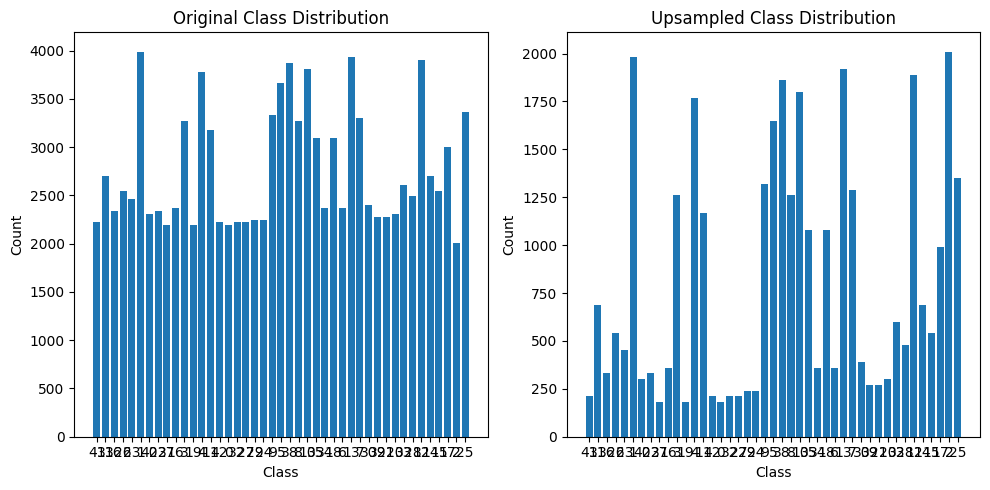

In [42]:
import matplotlib.pyplot as plt

# Count the number of samples in each class
class_counts = {}
for label in train_labels:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Count the number of samples in each class after upsampling
upsampled_class_counts = {}
for label in upsampled_labels:
    if label in upsampled_class_counts:
        upsampled_class_counts[label] += 1
    else:
        upsampled_class_counts[label] = 1

# Plot the class distribution
labels = [str(label) for label in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Original Class Distribution')

labels_upsampled = [str(label) for label in upsampled_class_counts.keys()]
counts_upsampled = list(upsampled_class_counts.values())

plt.subplot(1, 2, 2)
plt.bar(labels_upsampled, counts_upsampled)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Upsampled Class Distribution')

plt.tight_layout()
plt.show()


##Visualize the output of multiple random images on different layers of your network and try to explain them

Here we have a code snippet that shows the mean feature plots for different random images in different layers of the network.

1. **Select random images**: This code selects a certain number of random images from the test data set. The variable `num_images` determines the number of random images and the variable `random_indices` stores the randomly selected indices.

2. **Setting the layer index**: The variable `layer_index' determines the index of the layer we want to show its feature graphs. You can change this index to display different layers of the network.

3. **Creating an intermediate model**: A new model named ``intermediate_model'' is created, which includes the layers of the original model up to the selected layer. This is done using the ``nn.Sequential'' module and passing a subset of the original model's children to the selected layer's index.

4. **Setting the evaluation mode for the model**: ``intermediate_model'' is set to the evaluation mode using ``eval()'' method. This will cause any layer such as Dropout or BatchNorm to be set to evaluation mode and not perform random operations or update batch statistics.

5. **Extraction of intermediate feature graphs**: Random images are passed through `intermediate_model' and intermediate feature graphs are obtained. This is done by combining random images in tensor form and sending it to the model. The `torch.no_grad()` content manager is used to disable gradient calculations at projection time to save memory and calculations.

6. **Display feature graphs**: The code shows the intermediate feature graphs. For each random image, a subgraph is created for each feature graph in the selected layer. ``imshow'' function is used to display the feature graph as an image in gray levels. The function `axis('off')` is called to remove the axis labels, and the title of each subplot displays the image number and its corresponding label.

7. **Display charts**: `plt.tight_layout()` function sets the spacing between subplots and `plt.show()` displays the charts.

By running this code, a grid is displayed where each row represents a random image and each column represents a different feature graph in the selected layer. This representation helps to understand how the network extracts and transforms information through different layers and provides an understanding of the internal representation of the network at different stages of processing.

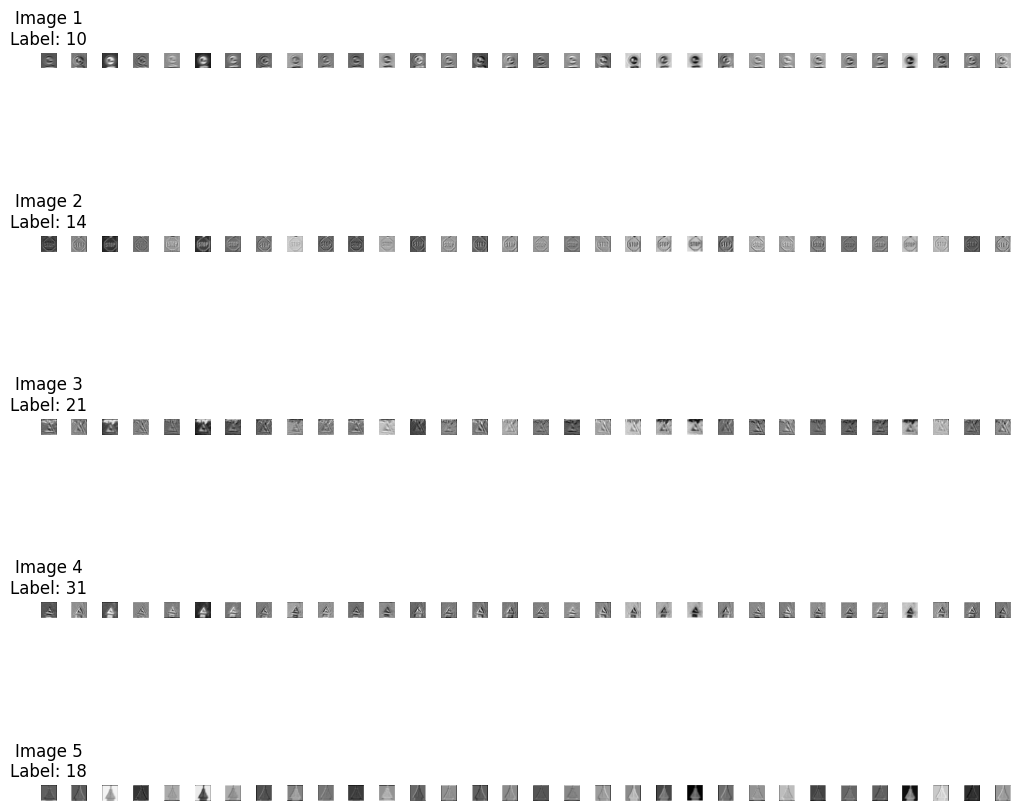

In [46]:
import matplotlib.pyplot as plt

# Choose random images from the test dataset
num_images = 5
random_indices = np.random.choice(len(test_dataset), size=num_images, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]
random_labels = [test_dataset[i][1] for i in random_indices]

# Set your desired layer index for visualization
layer_index = 1  # Change this to visualize different layers

# Create a new model with the layers until the chosen layer
intermediate_model = nn.Sequential(*list(model.children())[:layer_index + 1])
intermediate_model.to(device)

# Set the model to evaluation mode
intermediate_model.eval()

# Pass the random images through the model and extract the intermediate feature maps
with torch.no_grad():
    intermediate_outputs = intermediate_model(torch.stack(random_images).to(device))

# Visualize the intermediate feature maps
fig, axs = plt.subplots(num_images, intermediate_outputs.shape[1], figsize=(10, 10))
for i, image in enumerate(random_images):
    for j in range(intermediate_outputs.shape[1]):
        axs[i, j].imshow(intermediate_outputs[i, j].cpu(), cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f"Image {i+1}\nLabel: {random_labels[i]}")
plt.tight_layout()
plt.show()


In [47]:
import matplotlib.pyplot as plt

# Choose random images from the test dataset
num_images = 5
random_indices = np.random.choice(len(test_dataset), size=num_images, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]
random_labels = [test_dataset[i][1] for i in random_indices]

# Set your desired layer index for visualization
layer_index = 1  # Change this to visualize different layers

# Create a new model with the layers until the chosen layer
intermediate_model = nn.Sequential(*list(model.children())[:layer_index + 1])
intermediate_model.to(device)

# Set the model to evaluation mode
intermediate_model.eval()

# Pass the random images through the model and extract the intermediate feature maps
with torch.no_grad():
    intermediate_outputs = intermediate_model(torch.stack(random_images).to(device))

# Visualize the intermediate feature maps
fig, axs = plt.subplots(num_images, intermediate_outputs.shape[1], figsize=(15, 15))  # Increase figsize for larger images
for i, image in enumerate(random_images):
    for j in range(intermediate_outputs.shape[1]):
        axs[i, j].imshow(intermediate_outputs[i, j].cpu(), cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f"Image {i+1}\nLabel: {random_labels[i]}")
plt.tight_layout()
plt.show()


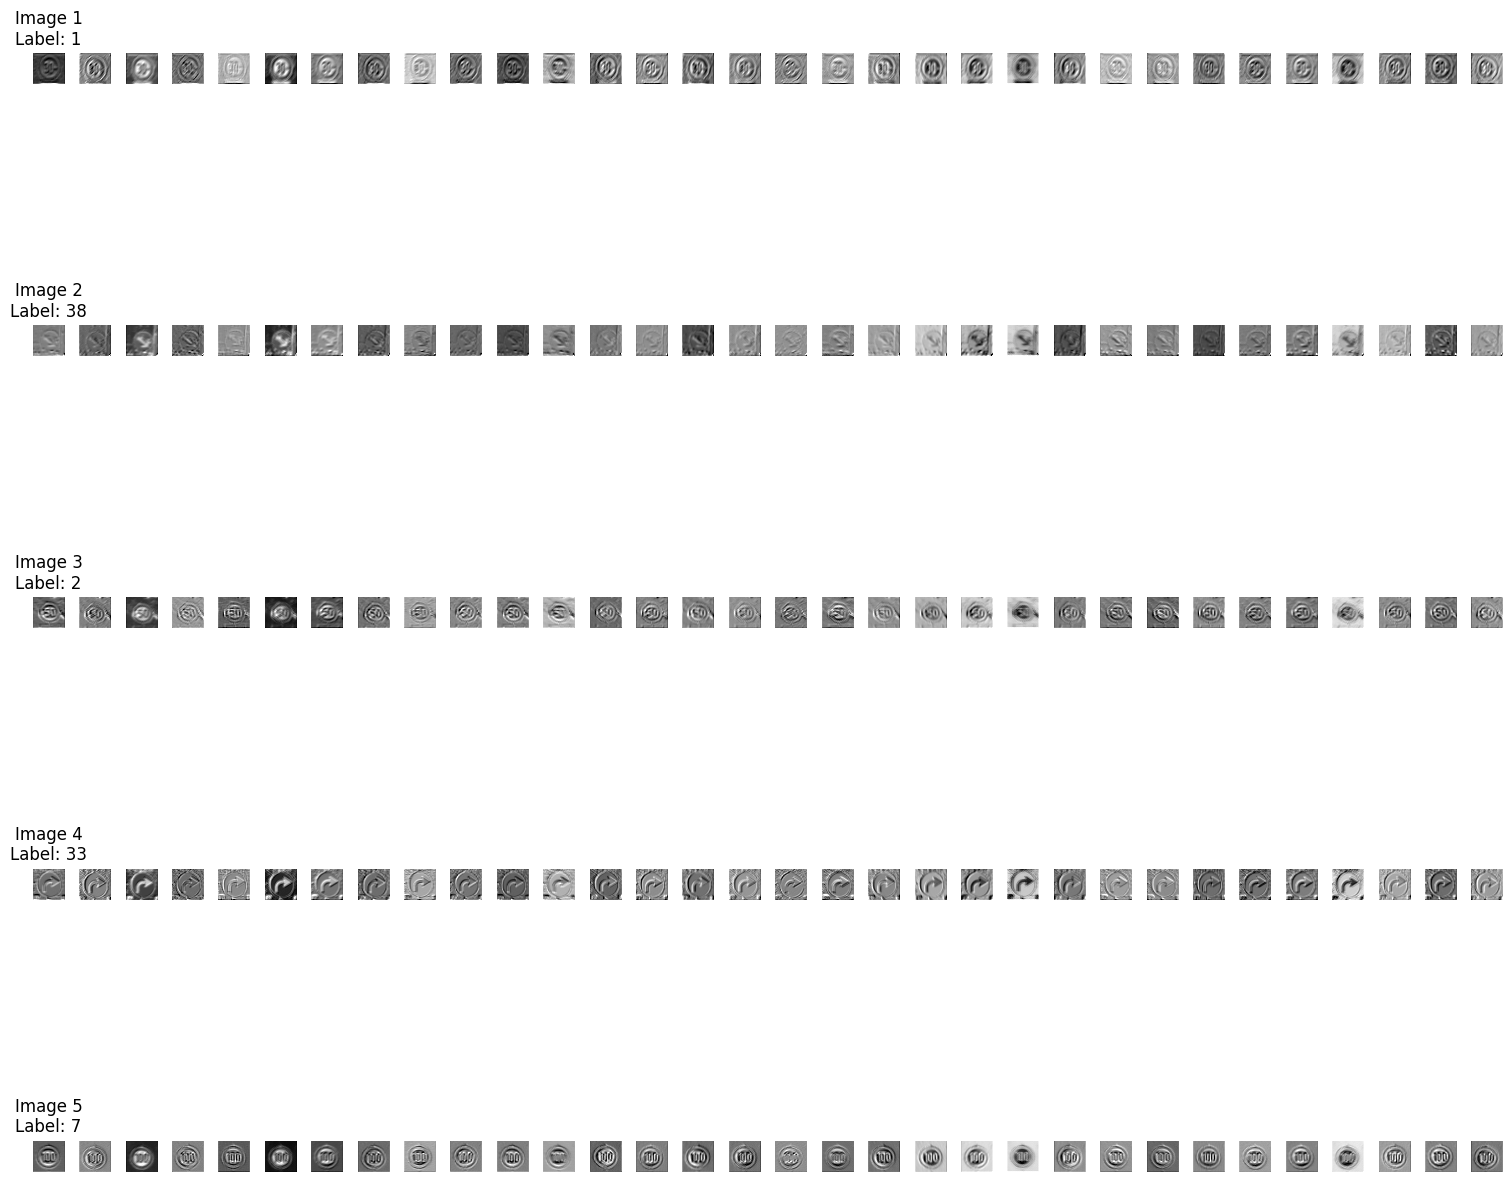

In [48]:
import matplotlib.pyplot as plt

# Choose random images from the test dataset
num_images = 5
random_indices = np.random.choice(len(test_dataset), size=num_images, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]
random_labels = [test_dataset[i][1] for i in random_indices]

# Set your desired layer index for visualization
layer_index = 1  # Change this to visualize different layers

# Create a new model with the layers until the chosen layer
intermediate_model = nn.Sequential(*list(model.children())[:layer_index + 1])
intermediate_model.to(device)

# Set the model to evaluation mode
intermediate_model.eval()

# Pass the random images through the model and extract the intermediate feature maps
with torch.no_grad():
    intermediate_outputs = intermediate_model(torch.stack(random_images).to(device))

# Visualize the intermediate feature maps
fig, axs = plt.subplots(num_images, intermediate_outputs.shape[1], figsize=(15, 15))  # Increase figsize for larger images
for i, image in enumerate(random_images):
    for j in range(intermediate_outputs.shape[1]):
        axs[i, j].imshow(intermediate_outputs[i, j].cpu(), cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f"Image {i+1}\nLabel: {random_labels[i]}")
plt.tight_layout()
plt.show()


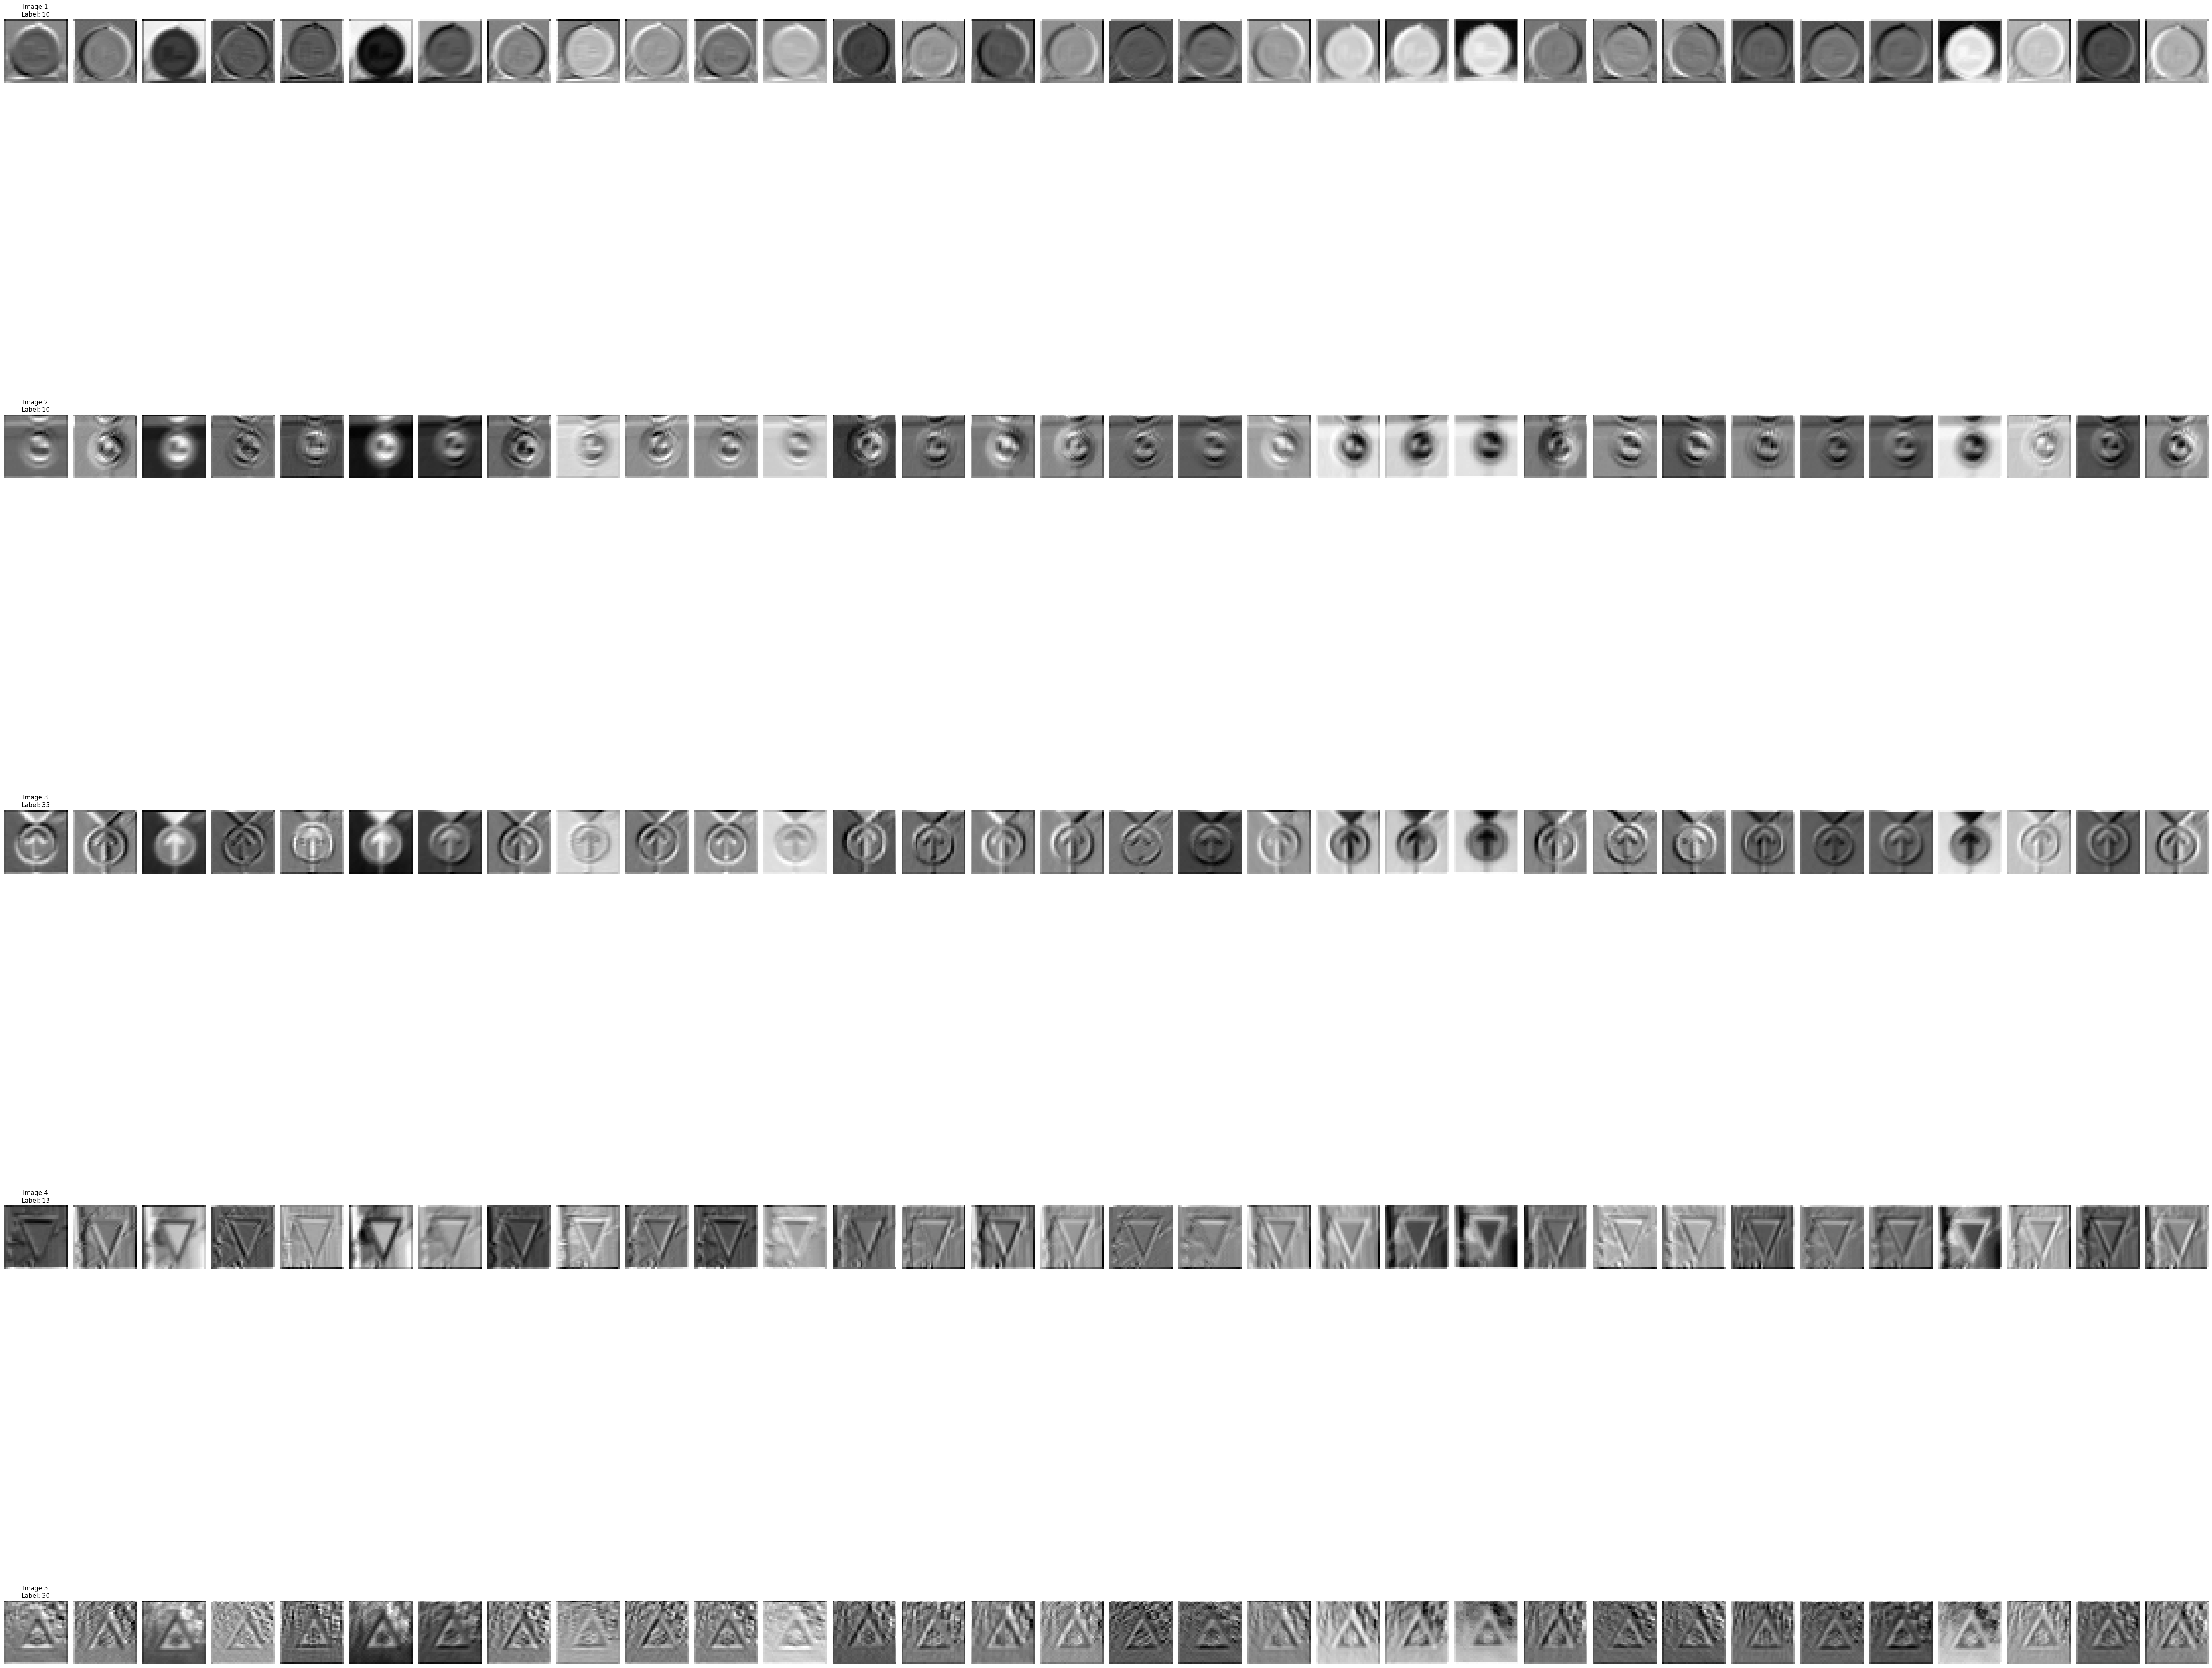

In [49]:
import matplotlib.pyplot as plt

# Choose random images from the test dataset
num_images = 5
random_indices = np.random.choice(len(test_dataset), size=num_images, replace=False)
random_images = [test_dataset[i][0] for i in random_indices]
random_labels = [test_dataset[i][1] for i in random_indices]

# Set your desired layer index for visualization
layer_index = 1  # Change this to visualize different layers

# Create a new model with the layers until the chosen layer
intermediate_model = nn.Sequential(*list(model.children())[:layer_index + 1])
intermediate_model.to(device)

# Set the model to evaluation mode
intermediate_model.eval()

# Pass the random images through the model and extract the intermediate feature maps
with torch.no_grad():
    intermediate_outputs = intermediate_model(torch.stack(random_images).to(device))

# Visualize the intermediate feature maps
fig, axs = plt.subplots(num_images, intermediate_outputs.shape[1], figsize=(60,60))  # Increase figsize for larger images
for i, image in enumerate(random_images):
    for j in range(intermediate_outputs.shape[1]):
        axs[i, j].imshow(intermediate_outputs[i, j].cpu(), cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f"Image {i+1}\nLabel: {random_labels[i]}")
plt.tight_layout()
plt.show()


##Visualize different images in the train set and compare them in terms of illumination, aspect ratio, or other aspects. Try to use appropriate transformation to pre-process the images and boost your model’s performance. For, example in terms of illumination, if images differ considerably, you can use Histogram Equalization to solve the issue.

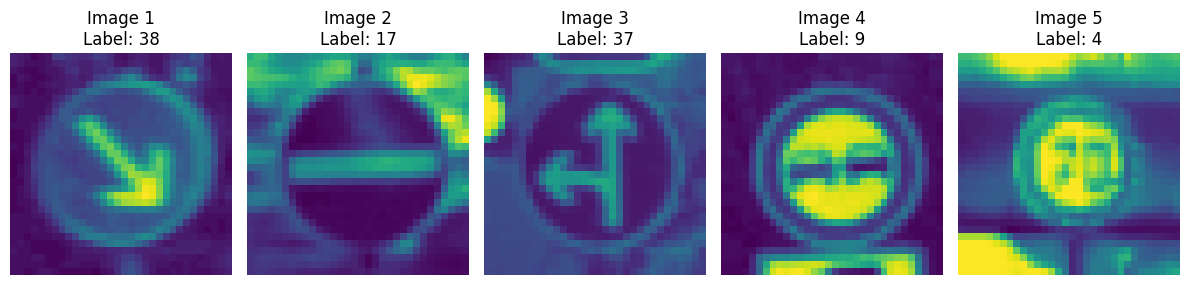

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
num_images = 5
random_indices = np.random.choice(len(train_dataset), size=num_images, replace=False)
random_images = [train_dataset[i][0] for i in random_indices]
random_labels = [train_dataset[i][1] for i in random_indices]
fig, axs = plt.subplots(1, num_images, figsize=(12, 3))

for i, image in enumerate(random_images):
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].axis('off')
    axs[i].set_title(f"Image {i+1}\nLabel: {random_labels[i]}")

plt.tight_layout()
plt.show()


Here we demonstrate the innovation and preprocessing of random images from the training dataset using various transformations with a particular focus on dark equalization. Next, we explain each section:

1. Importing the necessary libraries:
    - ``matplotlib.pyplot'' library is imported as ``plt'' to control drawing and displaying the input image.
    - The `numpy' library is imported as `np' for numerical operations and changes to arrays.
    - `skimage.exposure' library is imported to access the dark equalization function.
    - The `torchvision.transforms.functional` library is imported as `TF` to convert Torch tensors to PIL images.

2. Selecting random images from the training data set:
    - The number of images we want to select is specified as `num_images`.
    - Random indices are selected from the training dataset without replacement using `np.random.choice`.
    - Randomly selected images and their labels are stored in `random_images` and `random_labels`.

3. Display the main images:
    - A figure with subplots is created using `plt.subplots'.
    - For each random image, we convert it to a PIL image using `TF.to_pil_image`.
    - The main image along with its label is drawn using `imshow` and `set_title`.
    - The resulting subplots are displayed using `plt.show`.

4. Convert Torch tensors to NumPy arrays:
    - Each random image is converted to a PIL image and then to a NumPy array using `TF.to_pil_image` and `np.array`.
    - Converted NumPy arrays are stored in `random_images_np`.

5. Apply appropriate transformations (equalization of darkness):
    - Darkness equalization is applied to each random image in `random_images_np` using `exposure.equalize_hist`.
    - Equalized images are stored in `equalized_images`.

6. Displaying pre-processed images:
    - Another figure is created with subplots to display original images and pre-processed images side by side.
    - Original images are drawn in the top row, while pre-processed images (after dark equalization) are drawn in the bottom row.
    - The title of each graph indicates whether it represents the original image or the result of dark equalization.
    - The resulting subplots are displayed using `plt.show`.

In general, this code helps to display random images from the training dataset, convert them to NumPy arrays, apply dark equalization and compare the original and preprocessed images to see the effect of this transformation.

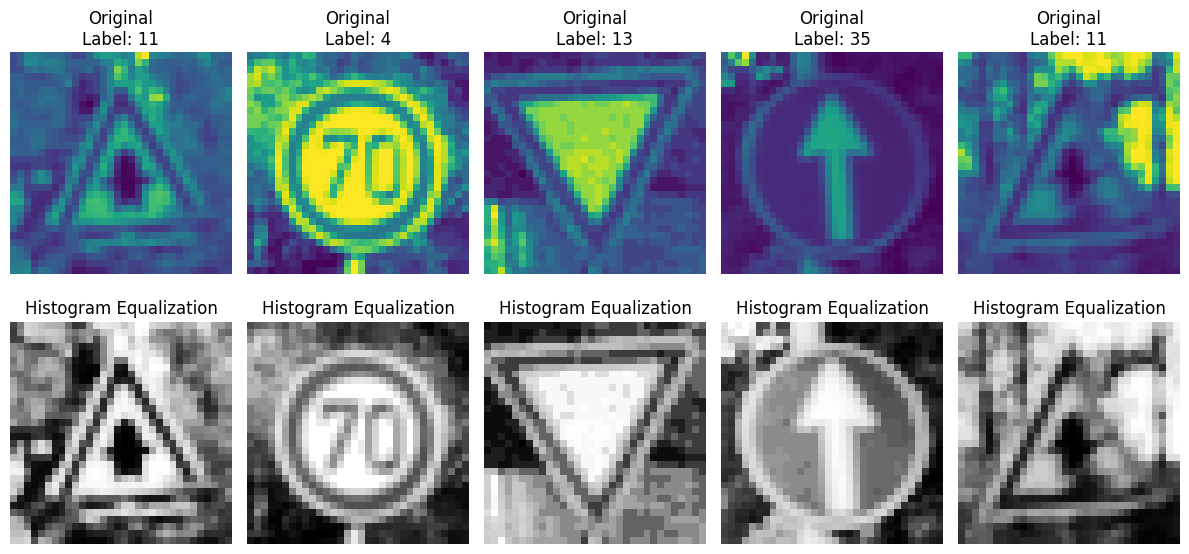

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import torchvision.transforms.functional as TF

# Choose random images from the train dataset
num_images = 5
random_indices = np.random.choice(len(train_dataset), size=num_images, replace=False)
random_images = [train_dataset[i][0] for i in random_indices]
random_labels = [train_dataset[i][1] for i in random_indices]

# Visualize the original images
fig, axs = plt.subplots(1, num_images, figsize=(12, 3))
for i, image in enumerate(random_images):
    axs[i].imshow(TF.to_pil_image(image))
    axs[i].axis('off')
    axs[i].set_title(f"Image {i+1}\nLabel: {random_labels[i]}")
plt.tight_layout()
plt.show()

# Convert Torch tensors to NumPy arrays
random_images_np = [np.array(TF.to_pil_image(image).convert("L")) for image in random_images]

# Apply appropriate transformations (e.g., Histogram Equalization)
equalized_images = [exposure.equalize_hist(image) for image in random_images_np]

# Visualize the preprocessed images
fig, axs = plt.subplots(2, num_images, figsize=(12, 6))

# Plot original images
for i, image in enumerate(random_images):
    axs[0, i].imshow(TF.to_pil_image(image))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Original\nLabel: {random_labels[i]}")

# Plot preprocessed images
for i, image in enumerate(equalized_images):
    axs[1, i].imshow(image, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Histogram Equalization")

plt.tight_layout()
plt.show()


In [55]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Custom transform with histogram equalization
class HistogramEqualizationTransform:
    def __init__(self):
        pass

    def __call__(self, image):
        image_np = np.array(image)

        # Apply histogram equalization
        image_eq = self.histogram_equalization(image_np)

        # Convert back to PIL image
        image_eq = Image.fromarray(image_eq)

        return image_eq

    def histogram_equalization(self, image):
        hist, bins = np.histogram(image.flatten(), bins=256, range=(0, 255))
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()

        image_eq = np.interp(image.flatten(), bins[:-1], cdf_normalized)
        image_eq = image_eq.reshape(image.shape)

        return image_eq.astype(np.uint8)

# Apply transformations to the train dataset
train_transforms = transforms.Compose([
    HistogramEqualizationTransform(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_transformed = TrafficSignDataset(train_features, train_labels, transform=train_transforms)

# Select random images from the transformed train dataset
num_images = 5
random_indices = np.random.choice(len(train_dataset_transformed), size=num_images, replace=False)
images = [train_dataset_transformed[i][0] for i in random_indices]

# Visualize the original and transformed images
fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(train_dataset_transformed[random_indices[i]][0].permute(1, 2, 0))
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Transformed image
    axes[i, 1].imshow(images[i].permute(1, 2, 0))
    axes[i, 1].set_title("Transformed Image")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
